

This Notebook is a fork/extension to the original Keras_AE.ipynb-Notebook with the addition of starting training the machine learning models for each file inside the cleaned_data3-folder, instead of just one dataset.

Inspired by:
---
https://keras.io/examples/timeseries/timeseries_anomaly_detection/

Data has not been normalized on POC below; That could be good to do.

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
filecounter = 0
filename = ""
table_df = 0

In [110]:
import copy

Run multiple times from this codeblock to train machine learning model for each file inside the cleaned_data3-folder

In [112]:
project_root_dir = Path.cwd() / 'drive' / 'My Drive' / 'applied-data-hackathon' / 'predictive-maintenance'
files = sorted(list((project_root_dir / "cleaned_data3").glob("*.csv")))
index = 0
_columns = 0

while not index == len(files):
    if filecounter == len(files):
        raise SystemExit("Looped through all files in the folder!")
    file = files[index]
    if index == filecounter:
      
        filename = file.stem
        table_df = pd.read_csv(file, on_bad_lines="skip")
        _columns = copy.copy(table_df.columns)
        filecounter += 1
        if len(table_df.values)<100:
            print(f"dataset {filename} is too small")
            index = 0
        else:
            break
        
    index += 1
filecounter

3

In [113]:
table_df = table_df.iloc[: , 1:]

In [114]:
table_df

,key,drive5_torque,drive5_torque_sma,drive5_torque_std,drive5_time_since_motor_startup
0,18504866.0,0.292,NaN,NaN,1.0
1,18509861.0,0.269,NaN,NaN,1.0
2,18514857.0,0.301,NaN,NaN,1.0
3,18519857.0,0.270,NaN,NaN,1.0
4,18524866.0,0.282,NaN,NaN,1.0
...,...,...,...,...,...
20332,44224876.0,0.297,0.27914,0.028320,1.0
20333,44229872.0,0.276,0.27948,0.028175,1.0
20334,44234875.0,0.278,0.27970,0.028119,1.0
20335,44239874.0,0.256,0.27944,0.028279,1.0


In [115]:
del table_df["key"]

In [116]:
dimensions=0
def create_sequences(df, time_steps=100):
    output = []
    values = df.iloc[:, ].values
    dimensions = len(df.columns)
    print(dimensions,len(values),values)
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output).reshape(-1,time_steps,dimensions)

x_train = create_sequences(table_df)
del table_df
print("Training input shape: ", x_train.shape)
dimensions = x_train.shape[2]



4 20337 [[0.292             nan        nan 1.        ]
 [0.269             nan        nan 1.        ]
 [0.301             nan        nan 1.        ]
 ...
 [0.278      0.2797     0.02811874 1.        ]
 [0.256      0.27944    0.02827934 1.        ]
 [0.26       0.27946    0.02826493 1.        ]]
Training input shape:  (20238, 100, 4)


In [117]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 50, 32)            928       
                                                                 
 dropout_6 (Dropout)         (None, 50, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 16)            3600      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 50, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 50, 16)            0         
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 100, 32)          3616      
 Transpose)                                           

In [118]:
checkpoint_path = '/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/Keras_AE_checkpoints2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min')

history = model.fit(
    x_train,
    x_train,
    epochs=1,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        model_checkpoint_callback
    ]
    )

143/143 [==============================] - 8s 49ms/step - loss: nan - val_loss: nan


Test
---

In [119]:
table_df = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/total_data.csv', on_bad_lines="skip")
drive1_torque = table_df['drive1_torque']
drive2_torque = table_df['drive2_torque']
drive3_torque = table_df['drive3_torque']
drive4_torque = table_df['drive4_torque']
drive5_torque = table_df['drive5_torque']
drive6_torque = table_df['drive6_torque']
torques = pd.concat([drive1_torque,drive2_torque,drive3_torque,drive4_torque,drive5_torque,drive6_torque])
print(torques.tail())
training_mean = torques.mean()
training_std = torques.std()
table_df = (table_df - training_mean) / training_std

anomaly_noise = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/randoms.csv', on_bad_lines="skip")
anomaly_noise = (anomaly_noise - training_mean) / training_std
#anomaly_shifted = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/simulated_anomalies/drive4_torque.csv', on_bad_lines="skip")
anomaly_shifted = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/simulated_anomalies/drive4_torque.csv', on_bad_lines="skip")['high_value'].dropna()
anomaly_shifted = (anomaly_shifted - training_mean) / training_std
anomaly_shifted_down = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/simulated_anomalies/drive4_torque.csv', on_bad_lines="skip")['low_value'].dropna()
anomaly_shifted_down = (anomaly_shifted_down - training_mean) / training_std


99995    0.170
99996    0.155
99997    0.195
99998    0.211
99999    0.245
dtype: float64


In [123]:
print(dimensions)
#print(np.array(#(np.array([anomaly_shifted.values])*dimensions]).reshape(len(anomaly_shifted),dimensions).shape)
val = anomaly_shifted[0:100].values
input = np.array([[val]*dimensions]).reshape(-1,100,dimensions)
print(val)
model.predict(input).shape

4
[2.25443653 2.05345798 2.38842223 2.12045083 1.73524194 1.818983
 1.91947228 1.9529687  2.0869544  2.25443653 2.57265257 2.97460967
 2.70663827 1.88597585 1.63475266 1.71849372 1.56775981 1.98646513
 2.07020619 2.25443653 2.18744368 1.83573121 1.56775981 2.2209401
 2.27118474 2.20419189 2.07020619 2.33817759 2.13719904 2.15394725
 1.85247942 2.07020619 2.01996155 2.12045083 2.0869544  2.94111324
 3.05835073 2.80712754 1.91947228 1.71849372 1.58450802 1.93622049
 1.86922764 2.05345798 2.00321334 2.18744368 1.61800445 1.90272406
 2.07020619 2.2209401  1.85247942 2.0869544  2.10370261 2.42191865
 2.00321334 1.76873836 1.75199015 2.13719904 1.93622049 2.3549258
 2.77363112 3.05835073 2.58940078 2.17069546 1.63475266 1.83573121
 1.88597585 1.90272406 1.90272406 2.30468117 2.10370261 1.93622049
 2.01996155 2.23768832 2.0869544  2.13719904 2.00321334 2.27118474
 2.47216329 2.0869544  1.65150087 1.88597585 1.96971691 1.83573121
 2.30468117 2.72338648 2.80712754 2.84062397 2.03670976 1.551011

(1, 100, 1)

In [125]:
anomaly = anomaly_noise
for k in range(40):
  val = anomaly[100*k:100*k +100].values
  input = np.array([[val]*dimensions]).reshape(-1,100,dimensions)
  prediction = model.predict(input)
  train_mae_loss = np.mean(np.abs(prediction - input))
  print(train_mae_loss)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [126]:
#zeros test for off state
input = np.zeros(100*dimensions).reshape(-1,100,dimensions)
prediction = model.predict(input)
train_mae_loss = np.mean(np.abs(prediction[:,-1] - input), axis=0)
print(input)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0.

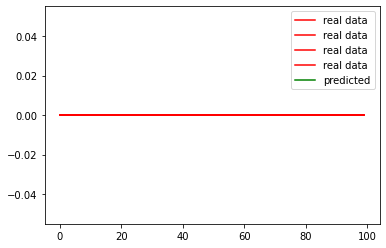

In [127]:
plt.plot(input[0],'r-',label='real data')
plt.plot(prediction[0],'g-',label='predicted')
plt.legend()
plt.show()

Visuals
---

       Unnamed: 0        key  drive1_velocity  drive1_gear  drive1_torque  \
0               0   18504866         -0.00002          3.0          0.000   
1               1   18509861          0.00001          3.0          0.000   
2               2   18514857          0.00002          3.0          0.000   
3               3   18519857         -0.00001          3.0          0.000   
4               4   18524866          0.00000          3.0          0.000   
...           ...        ...              ...          ...            ...   
99995       99995  518479862         50.08721          1.0          0.252   
99996       99996  518484870         50.16852          1.0          0.260   
99997       99997  518489864         50.05760          1.0          0.235   
99998       99998  518494859         50.01374          1.0          0.259   
99999       99999  518499863         49.97903          1.0          0.240   

       drive2_gear  drive3_gear  drive4_gear  drive5_gear  drive6_gear  ...

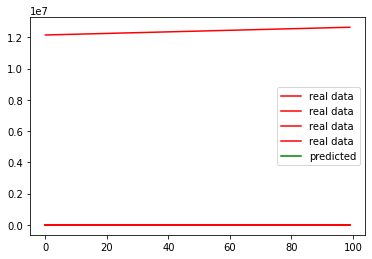

In [138]:
#input = np.array([anomaly_shifted[0:100].values.reshape(100,1)])
table_df3 = pd.read_csv('/content/drive/My Drive/applied-data-hackathon/predictive-maintenance/total_data3.csv', on_bad_lines="skip")
print(table_df3)
table_df2 = pd.DataFrame(columns=_columns[2:])

for column in _columns[2:]:
    table_df2[column] = table_df3[column]
#table_df2 = table_df3[[_columns[2:]]]
attempt = 95000
input =  np.array([table_df2[attempt:attempt+100].values.reshape(100,dimensions)])
x_train_pred = model.predict(input)

plt.plot(input[0],'r-',label='real data')
plt.plot(x_train_pred[0],'g-',label='predicted')
plt.legend()
plt.show()